# FDL 2019 - Floods

Load in any libraries and datasets needed

In [1]:
gp:.p.import[`geopandas]
\l ml/ml.q 
\l ml/init.q

avs:.p.import[`sklearn.metrics]`:average_precision_score
mattab:{flip value flip x}
svc:.p.import[`sklearn.svm]`:SVC
array:.p.import[`numpy]`:array

Datasets include

Max height per day per stream

NLCD(imperveous) dataset collected in 2006,2011,2016

Flood warned levels from NOAA, based on lat,long

stream gage info i.e location,state, codes etc

basin attributes at each stream gage

In [2]:
nlcd06:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2006.csv 
nlcd11:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2011.csv 
nlcd16:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2016.csv 

warnings:gp[`:read_file]["data/national_shapefile_obs.shp"]
warnings:.ml.df2tab[warnings]

gages:("SSSSFFSSIFFFFFFFFSSISSSSFF";enlist ",") 0:`:data/usgs_gage_subset.csv

basin:("S",242#"F";enlist ",") 0:`:data/gages_with_basin_attr.csv

Linking the stream gages with corresponding rain gages based on site_no and date (per month). 

In [40]:
\l gagesdir/gagesdir  /will change name of loaddir

maxht:0!select max height by site_no,date from str

maxht[`site_no]:`${$[7=count x;"0",x;x]}each maxht[`site_no]

maxht:delete from maxht where height<0

strmonth:0!select by site_no,"m"$date from maxht

gages[`site_no]:`${$[7=count x;"0",x;x]}each string each gages[`site_no] /pad with 0 if len site=7

show httab:strmonth ij `site_no xkey select site_no,dec_lat_va,dec_long_v from gages

site_no  date    height dec_lat_va dec_long_v
---------------------------------------------
01200000 2009.07 3.8    41.65876   -73.52868 
01200000 2009.08 1.82   41.65876   -73.52868 
01200000 2009.09 1.29   41.65876   -73.52868 
01200000 2009.10 2.04   41.65876   -73.52868 
01200000 2009.11 1.71   41.65876   -73.52868 
01200000 2009.12 4.17   41.65876   -73.52868 
01200000 2010.01 2.8    41.65876   -73.52868 
01200000 2010.02 4.35   41.65876   -73.52868 
01200000 2010.03 6.17   41.65876   -73.52868 
01200000 2010.04 1.96   41.65876   -73.52868 
01200000 2010.05 1.22   41.65876   -73.52868 
01200000 2010.06 0.91   41.65876   -73.52868 
01200000 2010.07 0.76   41.65876   -73.52868 
01200000 2010.08 0.83   41.65876   -73.52868 
01200000 2010.09 1.5    41.65876   -73.52868 
01200000 2010.10 1.63   41.65876   -73.52868 
01200000 2010.11 1.8    41.65876   -73.52868 
01200000 2010.12 2.05   41.65876   -73.52868 
01200000 2011.01 2.15   41.65876   -73.52868 
01200000 2011.02 3.75   41.65876  

Get the rain data from prism

In [ ]:
\cd ../../

In [43]:
show precipall:raze {flip `site_no`long`lat`elv`date`ppt!flip value each 10_("SFFFDF";enlist ",")0: 
    hsym `$"data/prism/",string[x]} each key `:data/prism

precipall[`site_no]:`${$[7=count x;"0",x;x]}each string each precipall[`site_no]


site_no long     lat     elv  date       ppt 
---------------------------------------------
1367690 -74.5596 41.1053 1056 2019.01.01 0.94
1367690 -74.5596 41.1053 1056 2019.01.02 0   
1367690 -74.5596 41.1053 1056 2019.01.03 0   
1367690 -74.5596 41.1053 1056 2019.01.04 0   
1367690 -74.5596 41.1053 1056 2019.01.05 0.38
1367690 -74.5596 41.1053 1056 2019.01.06 0.79
1367690 -74.5596 41.1053 1056 2019.01.07 0   
1367690 -74.5596 41.1053 1056 2019.01.08 0.02
1367690 -74.5596 41.1053 1056 2019.01.09 0.15
1367690 -74.5596 41.1053 1056 2019.01.10 0   
1367690 -74.5596 41.1053 1056 2019.01.11 0   
1367690 -74.5596 41.1053 1056 2019.01.12 0   
1367690 -74.5596 41.1053 1056 2019.01.13 0   
1367690 -74.5596 41.1053 1056 2019.01.14 0   
1367690 -74.5596 41.1053 1056 2019.01.15 0   
1367690 -74.5596 41.1053 1056 2019.01.16 0   
1367690 -74.5596 41.1053 1056 2019.01.17 0   
1367690 -74.5596 41.1053 1056 2019.01.18 0.06
1367690 -74.5596 41.1053 1056 2019.01.19 0   
1367690 -74.5596 41.1053 1056 2019

Some rain sites are missing the last digits of their id number so have to preprocess to get it to match the stream gages

In [44]:
rms:asc ds where 12<count each string each ds:exec distinct site_no from gages 
names:0!select i by site_no from precipall where site_no in `$12#'string each rms

{![`precipall;enlist (in;`i;y);0b;(enlist `site_no)!enlist enlist x]}'[rms[til[20],23 24 25];
    names[`x][til[19],21 22 23 24]]

matchnames:0!select i by lat,long from precipall where i in names[`x][20]
{![`precipall;enlist (in;`i;y);0b;(enlist `site_no)!enlist enlist x]}'[rms[21 22];matchnames[`x]]

`precipall`precipall`precipall`precipall`precipall`precipall`precipall`precip..


`precipall`precipall


Get stats on each rain gage per month,uid (id of raingage)

In [9]:
show rainmonth:1_0!select first distinct lat,first distinct long,sumpr:sum ppt,
    maxpre:max ppt,minpre:min ppt,avgpre:avg ppt,varpre:var ppt,max deltas ppt by site_no
    ,"m"$date from precipall

site_no  date    lat     long     sumpr maxpre minpre avgpre     varpre     p..
-----------------------------------------------------------------------------..
01200000 2009.07 41.6588 -73.5287 8.01  2.04   0      0.2583871  0.2031039  1..
01200000 2009.08 41.6588 -73.5287 5.94  1.59   0      0.1916129  0.1258458  1..
01200000 2009.09 41.6588 -73.5287 1.55  0.85   0      0.05166667 0.02672056 0..
01200000 2009.10 41.6588 -73.5287 4.51  1.46   0      0.1454839  0.1004828  1..
01200000 2009.11 41.6588 -73.5287 1.52  0.49   0      0.05066667 0.01351289 0..
01200000 2009.12 41.6588 -73.5287 5.61  0.93   0      0.1809677  0.08818939 0..
01200000 2010.01 41.6588 -73.5287 2.82  1.75   0      0.09096774 0.0974539  1..
01200000 2010.02 41.6588 -73.5287 4.41  2.28   0      0.1575     0.1941045  1..
01200000 2010.03 41.6588 -73.5287 6.5   1.36   0      0.2096774  0.1715322  1..
01200000 2010.04 41.6588 -73.5287 2.17  0.57   0      0.07233333 0.01860456 0..
01200000 2010.05 41.6588 -73.5287 1.93  

### Basin Characteristics

Take out columns that depend on the date like 09,10,11. Link it with previous table

In [10]:
cols09:where (count each ss[;"2006"]each string each cols basin)<>0
cols10:where (count each ss[;"2010"]each string each cols basin)<>0
cols11:where (count each ss[;"2011"]each string each cols basin)<>0

In [11]:
constcols:(til count[cols basin]) except raze 
    {where (count each ss[;x]each string each cols basin)<>0}each ("2009";"2010";"2011")

basinupd:flip (cols basin)[constcols]!basin[(cols basin)[constcols]]

show joinedtab:rainmonth ij `site_no xkey basinupd

site_no  date    lat     long     sumpr maxpre minpre avgpre     varpre     p..
-----------------------------------------------------------------------------..
01200000 2009.07 41.6588 -73.5287 8.01  2.04   0      0.2583871  0.2031039  1..
01200000 2009.08 41.6588 -73.5287 5.94  1.59   0      0.1916129  0.1258458  1..
01200000 2009.09 41.6588 -73.5287 1.55  0.85   0      0.05166667 0.02672056 0..
01200000 2009.10 41.6588 -73.5287 4.51  1.46   0      0.1454839  0.1004828  1..
01200000 2009.11 41.6588 -73.5287 1.52  0.49   0      0.05066667 0.01351289 0..
01200000 2009.12 41.6588 -73.5287 5.61  0.93   0      0.1809677  0.08818939 0..
01200000 2010.01 41.6588 -73.5287 2.82  1.75   0      0.09096774 0.0974539  1..
01200000 2010.02 41.6588 -73.5287 4.41  2.28   0      0.1575     0.1941045  1..
01200000 2010.03 41.6588 -73.5287 6.5   1.36   0      0.2096774  0.1715322  1..
01200000 2010.04 41.6588 -73.5287 2.17  0.57   0      0.07233333 0.01860456 0..
01200000 2010.05 41.6588 -73.5287 1.93  

### NLCD Dataset

Join NLCD (impervious info) to each station based on date. Only 3 datasets so link back in time

Only pick columns with some variance between stations

In [12]:
nlcd06:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:6 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2006 from nlcd06
nlcd11:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:11 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2011 from nlcd11
nlcd16:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:16 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2016 from nlcd16

In [13]:
stryear:{$[x<2011;6;x<2016;11;16]}each `year$joinedtab[`date]

merged:update year:stryear from joinedtab

newjoinedtab:merged ij `site_no xkey (nlcd06,nlcd11,nlcd16)

# Getting the Target Data

Get the count per month that a station goes over a flood level, broken up into 4 categories-Action,Flood,Moderate and Major

In [14]:
/Some gages have no threshold values so had to delete them from dataset
dela:first asc exec i by Action from warnings
delmj:first 1_asc exec i by Major from warnings
delmd:first 2_asc exec i by Moderate from warnings
delfl:first 2_asc exec i by Flood from warnings

warning:update nn: i from select from warnings where not i in distinct (dela,delmj,delmd,delfl)

Join based on nn

In [15]:
tabw:.ml.clust.kd.buildtree[warnlatl:gages[`dec_lat_va`dec_long_v],'"F"$'string each warning[`Latitude`Longitude];2]

nnwarn:.ml.clust.kd.i.nns[;tabw;(count[warning]#0),count[gages]#1;flip warnlatl;`edist
    ]each count[warning]+til count gages

In [16]:
joins:flip `nn`ndw`site_no!(nnwarn[;0];nnwarn[;1];gages[`site_no])

floodlvl:(maxht ij `site_no xkey joins) lj `nn xkey warning

floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

floodlvl[`site_no]:`${$[7=count x;"0",x;x]}each string each floodlvl[`site_no] /pad with 0 if len site=7

In [17]:
show target:0!select distinct Action,distinct Flood,distinct Moderate,distinct Major,no_Action:count where height>Action
 ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where height>Major by site_no
    ,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 17     19    22       24    0         0        0      0       
01200000 2009.08 17     19    22       24    0         0        0      0       
01200000 2009.09 17     19    22       24    0         0        0      0       
01200000 2009.10 17     19    22       24    0         0        0      0       
01200000 2009.11 17     19    22       24    0         0        0      0       
01200000 2009.12 17     19    22       24    0         0        0      0       
01200000 2010.01 17     19    22       24    0         0        0      0       
01200000 2010.02 17     19    22       24    0         0        0      0       
01200000 2010.03 17     19    22       24    0         0        0      0       
01200000 2010.04 17     19    22       24    0         0        0      0       
01200000 2010.05 17     19    22       2

In [18]:
show allmerged:newjoinedtab ij `site_no`date xkey target


site_no  date    lat     long     sumpr maxpre minpre avgpre     varpre     p..
-----------------------------------------------------------------------------..
01200000 2009.07 41.6588 -73.5287 8.01  2.04   0      0.2583871  0.2031039  1..
01200000 2009.08 41.6588 -73.5287 5.94  1.59   0      0.1916129  0.1258458  1..
01200000 2009.09 41.6588 -73.5287 1.55  0.85   0      0.05166667 0.02672056 0..
01200000 2009.10 41.6588 -73.5287 4.51  1.46   0      0.1454839  0.1004828  1..
01200000 2009.11 41.6588 -73.5287 1.52  0.49   0      0.05066667 0.01351289 0..
01200000 2009.12 41.6588 -73.5287 5.61  0.93   0      0.1809677  0.08818939 0..
01200000 2010.01 41.6588 -73.5287 2.82  1.75   0      0.09096774 0.0974539  1..
01200000 2010.02 41.6588 -73.5287 4.41  2.28   0      0.1575     0.1941045  1..
01200000 2010.03 41.6588 -73.5287 6.5   1.36   0      0.2096774  0.1715322  1..
01200000 2010.04 41.6588 -73.5287 2.17  0.57   0      0.07233333 0.01860456 0..
01200000 2010.05 41.6588 -73.5287 1.93  

In [19]:
/Tidy up some column types
allmerged[`site_no]:"F"$string each allmerged[`site_no]
allmerged[`lat`long]:raze each "F"$'string each allmerged[`lat`long]
allmerged[`Action]:raze allmerged[`Action]
allmerged[`Flood]:raze allmerged[`Flood]
allmerged[`Moderate]:raze allmerged[`Moderate]
allmerged[`Major]:raze allmerged[`Major]

In [20]:
allmerged:update month:`mm$date from allmerged

### Machine Learning Model

In [21]:
tgts:select site_no,no_Action,no_Flood,no_Mod,no_Major from allmerged
allmerged:delete no_Action,no_Flood,no_Mod,no_Major from allmerged

In [22]:
show tabreduced:`site_no`date xkey .ml.dropconstant[.ml.filltab[allmerged;`site_no;`date;::]]

site_no date   | lat     long     sumpr maxpre avgpre     varpre     ppt  Cat..
---------------| ------------------------------------------------------------..
1200000 2009.07| 41.6588 -73.5287 8.01  2.04   0.2583871  0.2031039  1.7  0.7..
1200000 2009.08| 41.6588 -73.5287 5.94  1.59   0.1916129  0.1258458  1.59 0.7..
1200000 2009.09| 41.6588 -73.5287 1.55  0.85   0.05166667 0.02672056 0.71 0.7..
1200000 2009.10| 41.6588 -73.5287 4.51  1.46   0.1454839  0.1004828  1.34 0.7..
1200000 2009.11| 41.6588 -73.5287 1.52  0.49   0.05066667 0.01351289 0.34 0.7..
1200000 2009.12| 41.6588 -73.5287 5.61  0.93   0.1809677  0.08818939 0.93 0.7..
1200000 2010.01| 41.6588 -73.5287 2.82  1.75   0.09096774 0.0974539  1.68 0.7..
1200000 2010.02| 41.6588 -73.5287 4.41  2.28   0.1575     0.1941045  1.79 0.7..
1200000 2010.03| 41.6588 -73.5287 6.5   1.36   0.2096774  0.1715322  1.36 0.7..
1200000 2010.04| 41.6588 -73.5287 2.17  0.57   0.07233333 0.01860456 0.26 0.7..
1200000 2010.05| 41.6588 -73.5287 1.93  

Standardised scaling is preformed on some of the columns

In [23]:
stdtab:.ml.stdscaler[delete lat,long from value tabreduced]
newtab:`site_no`date xkey (select site_no,date,lat,long from 0!tabreduced),'stdtab

The train and test set are strictly divided so that each station is either in train or test so that there is no data leakage

In [24]:
tstsplt:250#distinct key[newtab][`site_no]
trainsplt:250_distinct key[newtab][`site_no]

In [25]:
xtrain:value select from newtab where site_no in trainsplt
xtest:value select from newtab where site_no in tstsplt

In [26]:
/predict for  Moderate floods
ytrain:(exec no_Flood from tgts where site_no in trainsplt)>0
ytest:(exec no_Flood from tgts where site_no in tstsplt)>0


In [27]:
/backfilling per site doesn't work as nulls for all site, will look more into that
xtr:(mattab xtrain)[(til count[mattab xtrain]) except where 0<>{count where x=0n}each mattab xtrain]
ytr:ytrain[(til count[mattab xtrain]) except where 0<>{count where x=0n}each mattab xtrain]

### Baseline Random Forest

In [28]:
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 200;`random_state pykw 1]
clf[`:fit][xtr;ytr]`;
pred1:clf[`:predict][mattab xtest]`

In [29]:
.ml.classreport[ytest;pred1]

class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9813554 0.9215442 0.9505098 25645  
1        | 0.264351  0.6168942 0.3701049 1172   
avg/total| 0.6228532 0.7692192 0.6603074 26817  


In [30]:
show acc:(count where pred1=ytest)%count[ytest]

0.9082299


0| 23633 2012
1| 449   723 


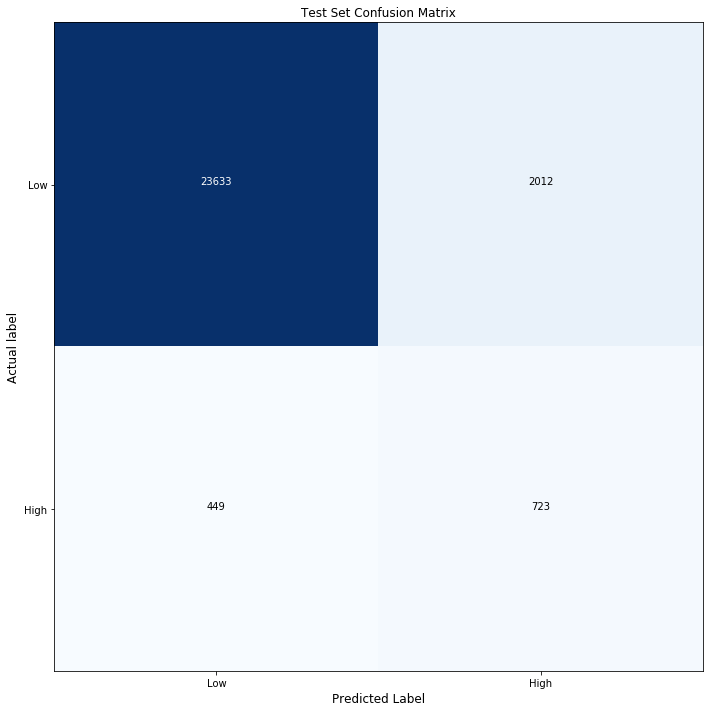

In [35]:
\l ml/fresh/notebooks/graphics.q
show cnfM:.ml.confmat[ytest;pred1]
conf:.ml.confdict[ytest;pred1;1b]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

In [36]:
show meanclassavg:avg (conf[`tp]%(sum conf[`tp`fn]);conf[`tn]%(sum conf[`tn`fp]))

0.7692192


### Neural Net

Import models needed for Neural Net

In [31]:
sequential:    .p.import[`keras.models]`:Sequential
dense:         .p.import[`keras.layers]`:Dense
normalization: .p.import[`keras.layers]`:BatchNormalization
pylist:        .p.import[`builtins]`:list
models:        .p.import[`keras]`:Model
inp:.p.import[`keras.layers]`:Input
km:.p.import[`keras_metrics]
plt:.p.import[`matplotlib]`:pyplot


Using TensorFlow backend.


In [32]:
inputl:inp[`shape pykw enlist 174]
output:dense[1;`activation pykw `softmax][inputl]
modl:models[`inputs pykw inputl;`outputs pykw output]
modl[`:compile][`optimizer pykw "adam";`loss pykw "binary_crossentropy";`metrics pykw (km[`:binary_precision][]`;km[`:binary_recall][]`)]

res:modl[`:fit][array[xtr];ytr;`batch_size pykw 100;`verbose pykw 1;`epochs pykw 100];


W0730 07:33:38.041311 139651601555456 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 07:33:38.063768 139651601555456 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 07:33:38.067466 139651601555456 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 07:33:38.097501 139651601555456 deprecation_wrapper.py:119] From /home/dianeodonoghue/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v

{[f;x]embedPy[f;x]}[foreign]enlist


2019-07-30 07:33:38.675013: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-30 07:33:38.684958: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-07-30 07:33:38.688355: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa177290 executing computations on platform Host. Devices:
2019-07-30 07:33:38.688429: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-07-30 07:33:38.789459: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

Epoch 1/100
44189/44189 [==============================] - ETA: 0s - loss: 13.0467 - precision: 0.1816 - recall: 1.00000 - ETA: 2s - loss: 12.9545 - precision: 0.1874 - recall: 1.0000  - ETA: 1s - loss: 12.9582 - precision: 0.1872 - recall: 1.00 - ETA: 0s - loss: 13.0677 - precision: 0.1803 - recall: 1.000 - ETA: 0s - loss: 13.0658 - precision: 0.1804 - recall: 1.000 - ETA: 0s - loss: 13.0522 - precision: 0.1813 - recall: 1.000 - ETA: 0s - loss: 13.0554 - precision: 0.1811 - recall: 1.000 - ETA: 0s - loss: 13.0483 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0485 - precision: 0.1815 - recall: 1.00 - ETA: 0s - loss: 13.0527 - precision: 0.1813 - recall: 1.000 - ETA: 0s - loss: 13.0548 - precision: 0.1811 - recall: 1.000 - ETA: 0s - loss: 13.0562 - precision: 0.1810 - recall: 1.000 - 1s 19us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 2/100
44189/44189 [==============================] - ETA: 0s - loss: 13.0870 - precision: 0.1791 - recall: 1.0000- ETA: 0s 

44189/44189 [==============================] - ETA: 0s - loss: 13.0709 - precision: 0.1801 - recall: 1.0000- ETA: 0s - loss: 13.0598 - precision: 0.1808 - recall: 1.000 - ETA: 0s - loss: 13.1208 - precision: 0.1770 - recall: 1.00 - ETA: 0s - loss: 13.0531 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0719 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0814 - precision: 0.1795 - recall: 1.00 - ETA: 0s - loss: 13.0630 - precision: 0.1806 - recall: 1.000 - ETA: 0s - loss: 13.0531 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0628 - precision: 0.1806 - recall: 1.000 - ETA: 0s - loss: 13.0598 - precision: 0.1808 - recall: 1.000 - 1s 14us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 11/100
44189/44189 [==============================] - ETA: 1s - loss: 13.7105 - precision: 0.1400 - recall: 1.000 - ETA: 0s - loss: 13.0254 - precision: 0.1830 - recall: 1.000 - ETA: 0s - loss: 13.1223 - precision: 0.1769 - recall: 1.000 - ETA: 0s - loss: 13.0756

44189/44189 [==============================] - 1s 15us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000: 0s - loss: 12.9680 - precision: 0.1866 - recall: 1.000 - ETA: 0s - loss: 13.0081 - precision: 0.1841 - recall: 1.000 - ETA: 0s - loss: 13.0743 - precision: 0.1799 - recall: 1.000 - ETA: 0s - loss: 13.0623 - precision: 0.1807 - recall: 1.000 - ETA: 0s - loss: 13.0448 - precision: 0.1818 - recall: 1.000 - ETA: 0s - loss: 13.0494 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0601 - precision: 0.1808 - recall: 1.000 - ETA: 0s - loss: 13.0541 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0489 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0494 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0571 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 13.0521 - precision: 0.1813 - recall: 1.000
Epoch 20/100
44189/44189 [==============================] - ETA: 1s - loss: 13.2322 - precision: 0.1700 - recall: 1.000 - ETA: 0s - loss: 13.0118 - p

44189/44189 [==============================] - ETA: 0s - loss: 13.0434 - precision: 0.1818 - recall: 1.000 - ETA: 0s - loss: 13.0494 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0557 - precision: 0.1811 - recall: 1.000 - ETA: 0s - loss: 13.0889 - precision: 0.1790 - recall: 1.000 - ETA: 0s - loss: 13.0641 - precision: 0.1805 - recall: 1.000 - ETA: 0s - loss: 13.0612 - precision: 0.1807 - recall: 1.000 - ETA: 0s - loss: 13.0474 - precision: 0.1816 - recall: 1.000 - ETA: 0s - loss: 13.0317 - precision: 0.1826 - recall: 1.000 - ETA: 0s - loss: 13.0569 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 13.0568 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 13.0563 - precision: 0.1810 - recall: 1.000 - 1s 14us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 31/100
44189/44189 [==============================] - ETA: 1s - loss: 12.9133 - precision: 0.1900 - recall: 1.000 - ETA: 0s - loss: 13.1158 - precision: 0.1773 - recall: 1.000 - ETA: 0s - loss: 13.08

44189/44189 [==============================] - ETA: 0s - loss: 13.0654 - precision: 0.1805 - recall: 1.0000- ETA: 0s - loss: 13.0576 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 13.1003 - precision: 0.1783 - recall: 1.000 - ETA: 0s - loss: 13.1070 - precision: 0.1779 - recall: 1.000 - ETA: 0s - loss: 13.0937 - precision: 0.1787 - recall: 1.000 - ETA: 0s - loss: 13.0841 - precision: 0.1793 - recall: 1.000 - ETA: 0s - loss: 13.0795 - precision: 0.1796 - recall: 1.000 - ETA: 0s - loss: 13.0803 - precision: 0.1795 - recall: 1.000 - ETA: 0s - loss: 13.0783 - precision: 0.1797 - recall: 1.000 - ETA: 0s - loss: 13.0709 - precision: 0.1801 - recall: 1.00 - ETA: 0s - loss: 13.0634 - precision: 0.1806 - recall: 1.000 - 1s 13us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 40/100
44189/44189 [==============================] - ETA: 1s - loss: 12.5945 - precision: 0.2100 - recall: 1.000 - ETA: 0s - loss: 12.9650 - precision: 0.1868 - recall: 1.000 - ETA: 0s - loss: 12.989

44189/44189 [==============================] - ETA: 0s - loss: 13.0357 - precision: 0.1823 - recall: 1.0000- ETA: 0s - loss: 12.9511 - precision: 0.1876 - recall: 1.000 - ETA: 0s - loss: 12.9629 - precision: 0.1869 - recall: 1.000 - ETA: 0s - loss: 13.0038 - precision: 0.1843 - recall: 1.000 - ETA: 0s - loss: 13.0294 - precision: 0.1827 - recall: 1.000 - ETA: 0s - loss: 13.0242 - precision: 0.1830 - recall: 1.000 - ETA: 0s - loss: 13.0447 - precision: 0.1818 - recall: 1.00 - ETA: 0s - loss: 13.0452 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0603 - precision: 0.1808 - recall: 1.000 - ETA: 0s - loss: 13.0641 - precision: 0.1805 - recall: 1.000 - ETA: 0s - loss: 13.0618 - precision: 0.1807 - recall: 1.000 - 1s 14us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 49/100
44189/44189 [==============================] - ETA: 0s - loss: 13.1264 - precision: 0.1766 - recall: 1.0000- ETA: 0s - loss: 13.2154 - precision: 0.1711 - recall: 1.0 - ETA: 0s - loss: 13.1336 

44189/44189 [==============================] - 1s 14us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000: 0s - loss: 12.9930 - precision: 0.1850 - recall: 1.000 - ETA: 0s - loss: 12.9801 - precision: 0.1858 - recall: 1.00 - ETA: 0s - loss: 12.9854 - precision: 0.1855 - recall: 1.000 - ETA: 0s - loss: 12.9948 - precision: 0.1849 - recall: 1.000 - ETA: 0s - loss: 13.0233 - precision: 0.1831 - recall: 1.000 - ETA: 0s - loss: 13.0479 - precision: 0.1816 - recall: 1.000 - ETA: 0s - loss: 13.0711 - precision: 0.1801 - recall: 1.00 - ETA: 0s - loss: 13.0590 - precision: 0.1809 - recall: 1.000 - ETA: 0s - loss: 13.0591 - precision: 0.1809 - recall: 1.000
Epoch 59/100
44189/44189 [==============================] - 1s 14us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000: 0s - loss: 12.9910 - precision: 0.1851 - recall: 1.000 - ETA: 0s - loss: 13.0458 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0367 - precision: 0.1823 - recall: 1.000 - ETA: 0s - loss: 13.1273 - pre

44189/44189 [==============================] - 1s 13us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000: 0s - loss: 13.0196 - precision: 0.1833 - recall: 1.000 - ETA: 0s - loss: 12.9672 - precision: 0.1866 - recall: 1.000 - ETA: 0s - loss: 13.0508 - precision: 0.1814 - recall: 1.000 - ETA: 0s - loss: 13.0203 - precision: 0.1833 - recall: 1.000 - ETA: 0s - loss: 13.0243 - precision: 0.1830 - recall: 1.000 - ETA: 0s - loss: 13.0403 - precision: 0.1820 - recall: 1.000 - ETA: 0s - loss: 13.0230 - precision: 0.1831 - recall: 1.000 - ETA: 0s - loss: 13.0475 - precision: 0.1816 - recall: 1.000 - ETA: 0s - loss: 13.0760 - precision: 0.1798 - recall: 1.000 - ETA: 0s - loss: 13.0653 - precision: 0.1805 - recall: 1.000 - ETA: 0s - loss: 13.0582 - precision: 0.1809 - recall: 1.000
Epoch 68/100
44189/44189 [==============================] - ETA: 1s - loss: 13.3916 - precision: 0.1600 - recall: 1.000 - ETA: 0s - loss: 13.1107 - precision: 0.1776 - recall: 1.000 - ETA: 0s - loss: 13.1335 - p

44189/44189 [==============================] - ETA: 0s - loss: 13.0558 - precision: 0.1811 - recall: 1.0000- ETA: 0s - loss: 12.9665 - precision: 0.1867 - recall: 1.000 - ETA: 0s - loss: 13.0094 - precision: 0.1840 - recall: 1.000 - ETA: 0s - loss: 13.0223 - precision: 0.1832 - recall: 1.000 - ETA: 0s - loss: 13.0462 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0351 - precision: 0.1824 - recall: 1.000 - ETA: 0s - loss: 13.0496 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0722 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.0712 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0700 - precision: 0.1802 - recall: 1.000 - ETA: 0s - loss: 13.0571 - precision: 0.1810 - recall: 1.00 - 1s 13us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 77/100
44189/44189 [==============================] - ETA: 1s - loss: 12.7539 - precision: 0.2000 - recall: 1.000 - ETA: 0s - loss: 13.2490 - precision: 0.1689 - recall: 1.000 - ETA: 0s - loss: 13.095

44189/44189 [==============================] - ETA: 0s - loss: 13.0836 - precision: 0.1793 - recall: 1.0000- ETA: 0s - loss: 13.0564 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 13.0376 - precision: 0.1822 - recall: 1.000 - ETA: 0s - loss: 13.0450 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0477 - precision: 0.1816 - recall: 1.000 - ETA: 0s - loss: 13.0577 - precision: 0.1809 - recall: 1.000 - ETA: 0s - loss: 13.0873 - precision: 0.1791 - recall: 1.000 - ETA: 0s - loss: 13.0828 - precision: 0.1794 - recall: 1.00 - ETA: 0s - loss: 13.0855 - precision: 0.1792 - recall: 1.000 - ETA: 0s - loss: 13.0911 - precision: 0.1788 - recall: 1.000 - ETA: 0s - loss: 13.0627 - precision: 0.1806 - recall: 1.000 - 1s 13us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 86/100
44189/44189 [==============================] - ETA: 1s - loss: 13.7105 - precision: 0.1400 - recall: 1.000 - ETA: 0s - loss: 13.0728 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.056

44189/44189 [==============================] - ETA: 0s - loss: 13.0391 - precision: 0.1821 - recall: 1.0000- ETA: 0s - loss: 13.2280 - precision: 0.1703 - recall: 1.000 - ETA: 0s - loss: 13.0874 - precision: 0.1791 - recall: 1.000 - ETA: 0s - loss: 13.1094 - precision: 0.1777 - recall: 1.000 - ETA: 0s - loss: 13.0886 - precision: 0.1790 - recall: 1.000 - ETA: 0s - loss: 13.0830 - precision: 0.1794 - recall: 1.000 - ETA: 0s - loss: 13.0577 - precision: 0.1809 - recall: 1.000 - ETA: 0s - loss: 13.0721 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.0572 - precision: 0.1810 - recall: 1.00 - ETA: 0s - loss: 13.0492 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0642 - precision: 0.1805 - recall: 1.000 - 1s 14us/step - loss: 13.0630 - precision: 0.1806 - recall: 1.0000
Epoch 95/100
44189/44189 [==============================] - ETA: 0s - loss: 13.0865 - precision: 0.1791 - recall: 1.0000- ETA: 0s - loss: 13.1177 - precision: 0.1772 - recall: 1.000 - ETA: 0s - loss: 13.097

In [33]:
show nnPred:raze(modl[`:predict]array[mattab xtest])`

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1..


loss     | 13.06302  13.06302  13.06302  13.06302  13.06302  13.06302  13.063..
precision| 0.1806106 0.1810183 0.1806106 0.1806106 0.1806106 0.1806106 0.1806..
recall   | 1         1         1         1         1         1         1     ..
loss     | 13.06302  13.06302  13.06302  13.06302  13.06302  13.06302  13.063..
precision| 0.1806106 0.1810183 0.1806106 0.1806106 0.1806106 0.1806106 0.1806..
recall   | 1         1         1         1         1         1         1     ..


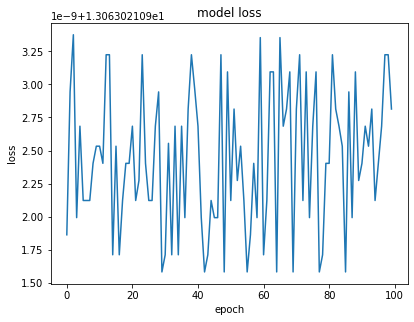

In [34]:
show hist:6#(res[`:history]`)

plt[`:plot]hist`loss;
plt[`:plot]hist`val_loss;
plt[`:title]"model loss";
plt[`:ylabel]"loss";
plt[`:xlabel]"epoch";
plt[`:show][];

0| 24082 2735
1| 0     0   


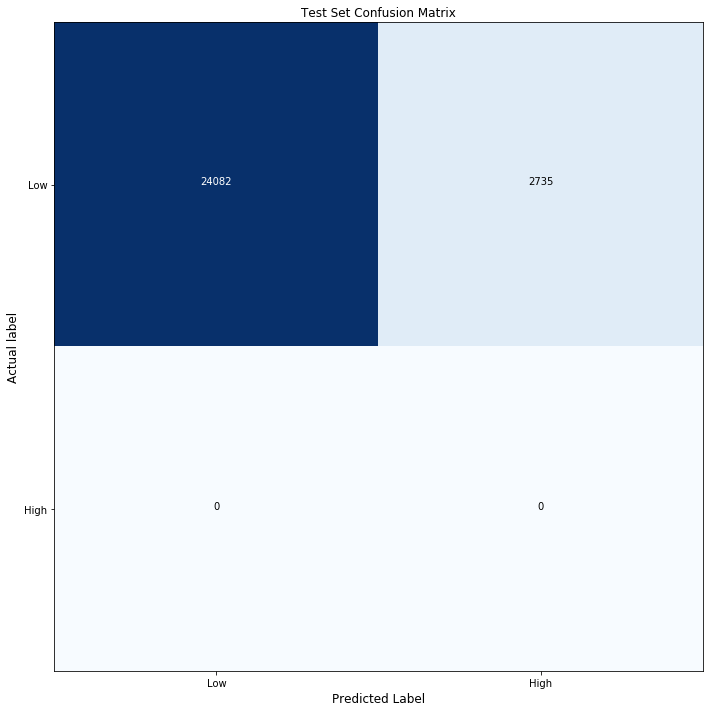

In [37]:
show cnfM:.ml.confmat[ytest;0.5>nnPred]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]